In [1]:
%load_ext autoreload
%autoreload all

import torch
import os

from omegaconf import OmegaConf

os.chdir('/GEM')
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

torch.cuda.empty_cache()
_rasterio_best_practices = {
    "GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR",
    "AWS_NO_SIGN_REQUEST": "YES",
    "GDAL_MAX_RAW_BLOCK_CACHE_SIZE": "200000000",
    "GDAL_SWATH_SIZE": "200000000",
    "VSI_CURL_CACHE_SIZE": "200000000",
}
os.environ.update(_rasterio_best_practices)

config_file = 'conf/dfc2022.yaml'
conf = OmegaConf.load(config_file)

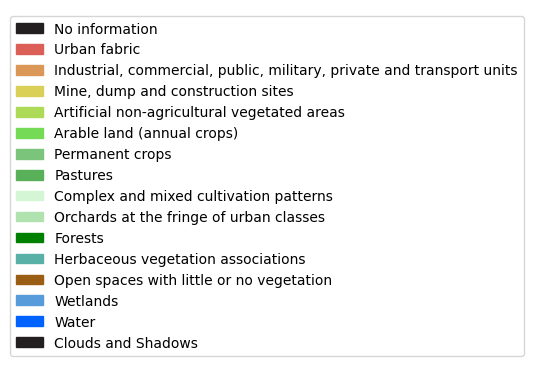

In [2]:
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from gem import DFC2022Dataset

handles = [Patch(color=c, label=l) for l, c in zip(DFC2022Dataset.classes, DFC2022Dataset.colormap)]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [3]:
import lightning as pl
import os

from gem import DFC2022DataModule, DFC2022SemanticSegmentationTask

pl.seed_everything(0)
task = DFC2022SemanticSegmentationTask(**conf.experiment.module)
datamodule = DFC2022DataModule(**conf.datamodule)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = datamodule.dataset.calc_class_weights().to(device)
print({name: weight.item() for name, weight in zip(DFC2022Dataset.classes, class_weights)})

Seed set to 0


{'No information': 0.0, 'Urban fabric': 11.941902160644531, 'Industrial, commercial, public, military, private and transport units': 19.064714431762695, 'Mine, dump and construction sites': 232.92881774902344, 'Artificial non-agricultural vegetated areas': 97.26484680175781, 'Arable land (annual crops)': 9.989909172058105, 'Permanent crops': 59.344722747802734, 'Pastures': 3.4119253158569336, 'Complex and mixed cultivation patterns': 0.0, 'Orchards at the fringe of urban classes': 0.0, 'Forests': 4.301761150360107, 'Herbaceous vegetation associations': 10.77350902557373, 'Open spaces with little or no vegetation': 44.760738372802734, 'Wetlands': 38.26409149169922, 'Water': 82.41312408447266, 'Clouds and Shadows': 0.0}


In [ ]:
trainer = pl.Trainer(**conf.trainer, detect_anomaly=True)
trainer.fit(model=task, datamodule=datamodule)

In [5]:
with open(os.path.join(trainer.logger.log_dir, "config.yaml"), "w") as f:
    OmegaConf.save(config=conf, f=f)

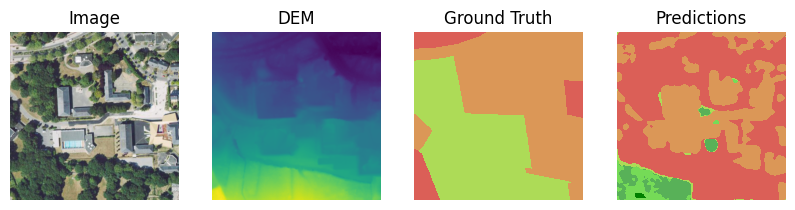

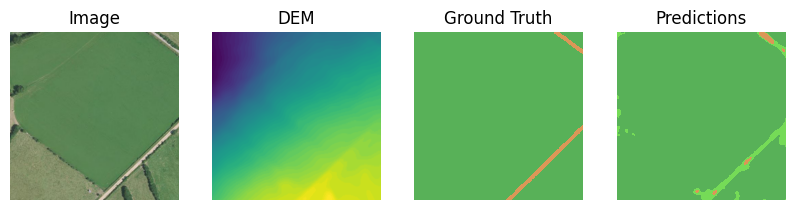

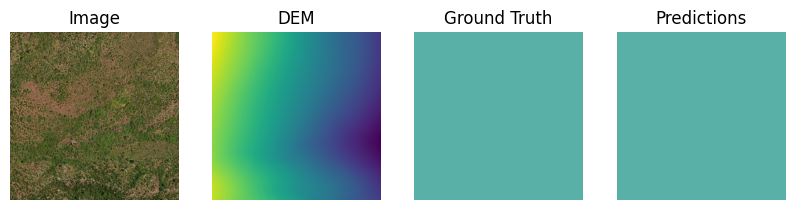

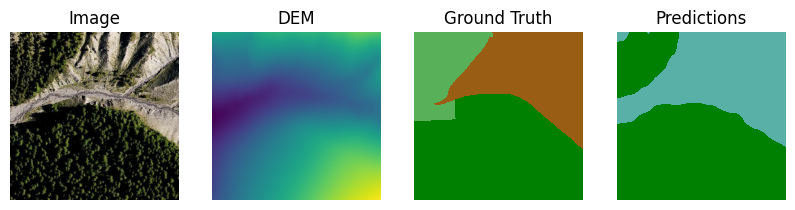

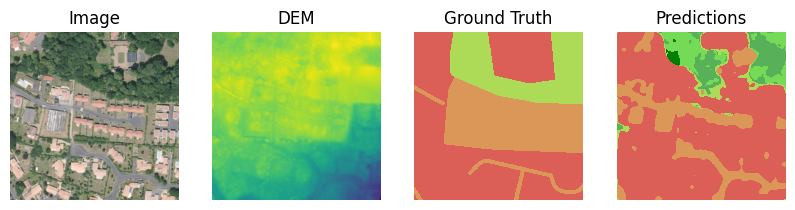

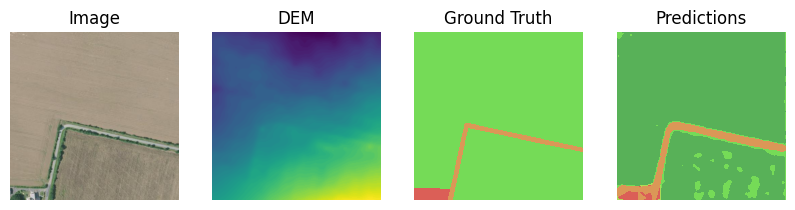

In [7]:
import torch
from gem.dataset import plot_batch

datamodule.setup()
val_iter = iter(datamodule.val_dataloader())
val_batches = [next(val_iter) for _ in range(6)]

# model = EarthMapping.load_from_checkpoint('/GEM/lightning_logs/version_26/checkpoints/epoch=69-step=70.ckpt')
# model = model.cpu()
task.eval()
with torch.no_grad():
    for batch in val_batches:
        preds = task(batch['image'])
        plot_batch(batch, preds, datamodule.dataset)